<a href="https://colab.research.google.com/github/duc-ke/kaggle-playground-group/blob/main/9.Surface-Crack-Outlier-Detection/Surface_Crack_Outlier_Detection-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 콘크리트의 비정상(금이 가있는) 이미지를 찾아내는 인공지능
* VAE를 이용한 Outlier Detection 구현
* 강점/장점 : 실제 데이터는 비정상적인 이미지는 구하기 어려움. 비정상 이미지를 학습시키기 어려움. 따라서 Outlier Detection을 이용하면 정상이미지만을 이용하여 outlier 를 찾아낼 수 있게 됨.

# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [1]:
# kaggle의 API token을 이용하여 데이터셋을 다운 받는다.
import os
os.environ['KAGGLE_USERNAME'] = 'kehyeong' # username
os.environ['KAGGLE_KEY'] = '' # key

In [2]:
!kaggle datasets download -d arunrk7/surface-crack-detection

100% 233M/233M [00:08<00:00, 35.0MB/s]
100% 233M/233M [00:08<00:00, 27.4MB/s]


In [3]:
!unzip -q surface-crack-detection.zip

# Install alibi_detect
* VAE를 이용한 Outlier Detection을 쓰기 위한 패키지 설치
* https://docs.seldon.io/projects/alibi-detect/en/latest/index.html


## VAE vs AE?
* AE는 이미지를 압축, 복원시키는데 목적
* VAE는 Generative model로 표준정규분포를 갖는 평균, 표준편차를 이용하여 확률에 기반한 latent space로 추출하였다가 노이즈를 추가하여 복원시킴 - AE보다 성능이 좋다.
* 한땀한땀 딥러닝 컴퓨터 비전 백과사전(위키독스) : https://wikidocs.net/152474
* 개인블로그(Medium) : https://medium.com/@seyong.dev/vae-variational-auto-encoder-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-60032f19b9e3


In [4]:
# 최신 버전은 아래 코드에 문제가 생길 수 있음.
!pip install alibi_detect==0.5.0

     |████████████████████████████████| 160 kB 38.6 MB/s 
     |████████████████████████████████| 4.8 MB 37.9 MB/s 
     |████████████████████████████████| 3.8 MB 62.6 MB/s 
     |████████████████████████████████| 394.5 MB 39 kB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 2.6 MB/s 
     |████████████████████████████████| 132 kB 73.0 MB/s 
     |████████████████████████████████| 462 kB 60.8 MB/s 
     |████████████████████████████████| 3.8 MB 57.1 MB/s 
     |████████████████████████████████| 14.8 MB 61.7 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 6.5 MB 20.3 MB/s 
     |████████████████████████████████| 596 kB 4.2 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68727 sha256=c9c6a58a78666b8f124cdbbd2362c495fc1d566e08a06294dada7a2790853002
  Stored in directory: /root/.c

# Import Packages

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images
- (N, W, H, C)로 구성
- Negative: normal images
- Positive: crack images

In [8]:
img_list = glob('Negative/*.jpg')
print('다운받은 전체 미지 갯수', len(img_list))

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021, shuffle=True)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:2000])
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list[:200])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

다운받은 전체 미지 갯수 20000
(2000, 64, 64, 3)
(200, 64, 64, 3)


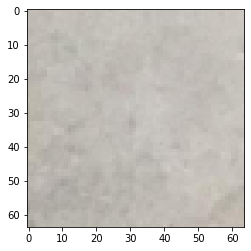

In [9]:
plt.imshow(x_train[0])

# Build Model

In [10]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),    # 1024
    Dense(4 * 4 * 128),                       # 2048
    Reshape(target_shape=(4, 4, 128)),        # 이미지 모양으로 W, H, C
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),    # (8, 8, 256)
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),    # (16, 16, 64)
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),    # (32, 32, 32)
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')    # (64, 64, 3)
])

od = OutlierVAE(
    threshold=.005,    # instance score가 이것보다 이하면 정상, 크면 비정상
    score_type='mse', 
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [11]:
od.fit(
    x_train,
    epochs=50,
    verbose=True
)

32/32 [=] - 2s 61ms/step - loss: -22571.5728


# Reconstruct Training Image

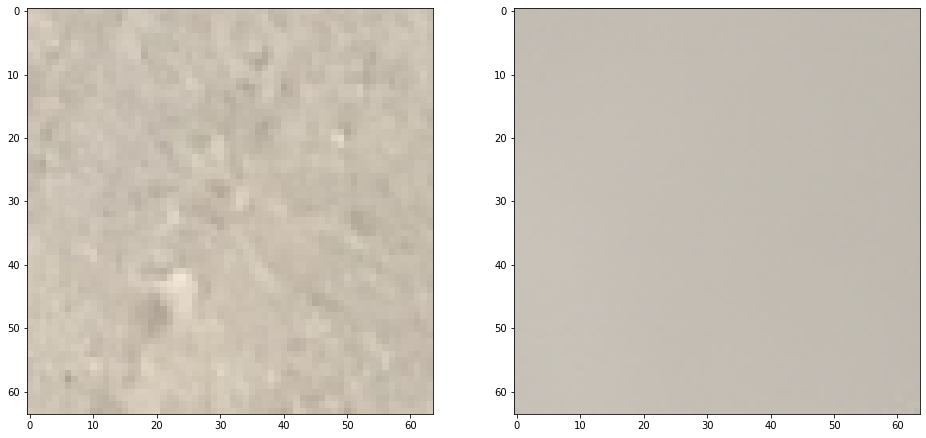

In [12]:
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()           # reconstruction -> np

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())     # 재 생성된 이미지

# Validation
* instance score 는 재생성된 이미지와의 차이를 의미
* 아래 초록선 위의 이미지는 비정상을 의미

(200,)


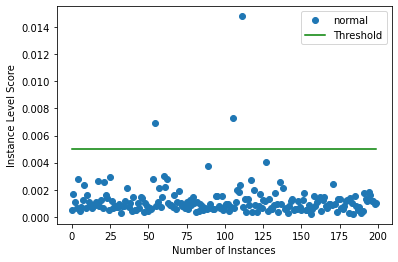

In [13]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',     # 픽셀 값을 뺀 값
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
print(target.shape)  # 32개의 0 np
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images
* original - reconstruction img => outlier score imgs per channels

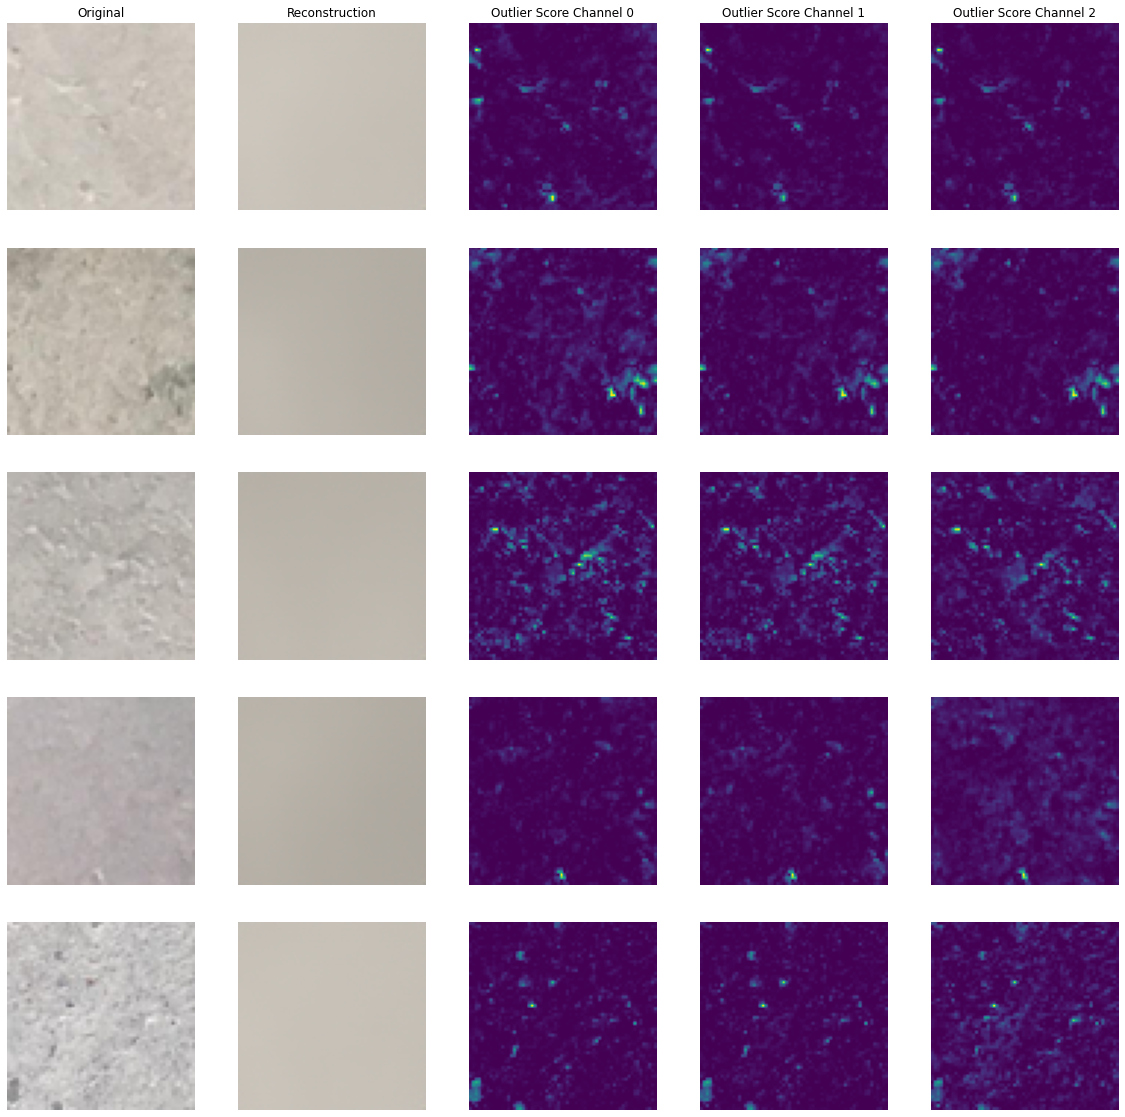

In [14]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False    # outlier 인지 아닌지 상관없이 모두 출력
)

# Outliers
* `outliers_only = True` 를 이용하여 outlier로 판정된 이미지만 본다.
* 아래 이미지들을 보면 질감과 색이 확연히 다른 애들만 보임.

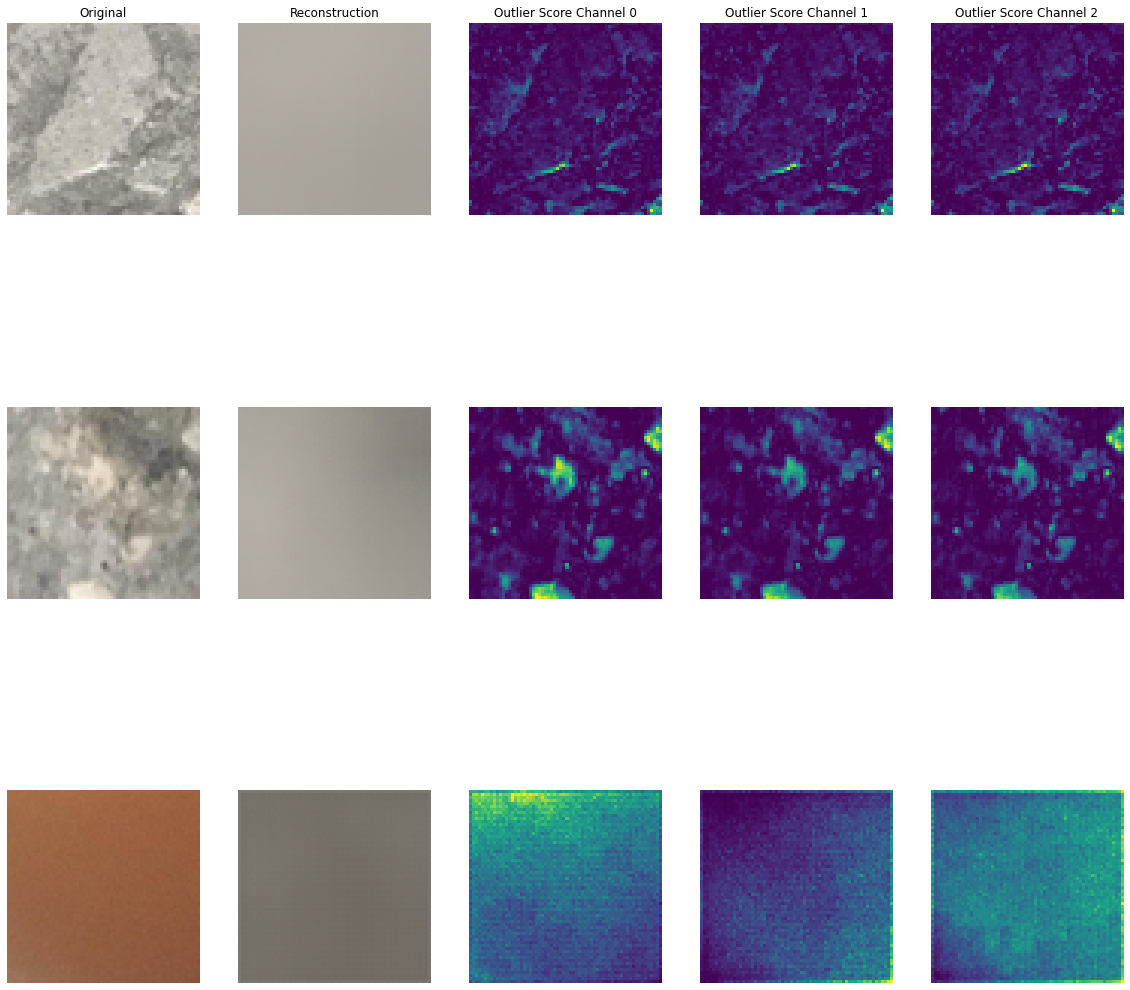

In [15]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

# Test with Crack Images
* 실제 금이 가있는 이미지를 넣고 score와 이미지를 확인해본다.
* 대부분 threshold보다 위에 있는 이미지들이 많다.

In [16]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


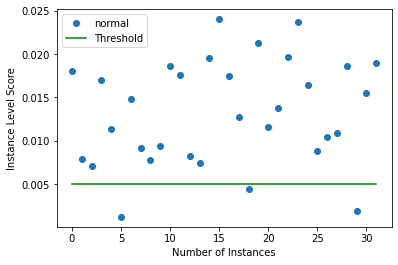

In [17]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruction with positive imgs
* 크랙이 있는 이미지로 reconstruction을 수행. 
* 정상이미지로 학습 시켰기 때문에 정상처럼 보이는 이미지가 생성됨.
* original - reconstruction -> instance score구함.
* crack이 있는 경우 굉장히 선이 잘보임을 알 수 있다.

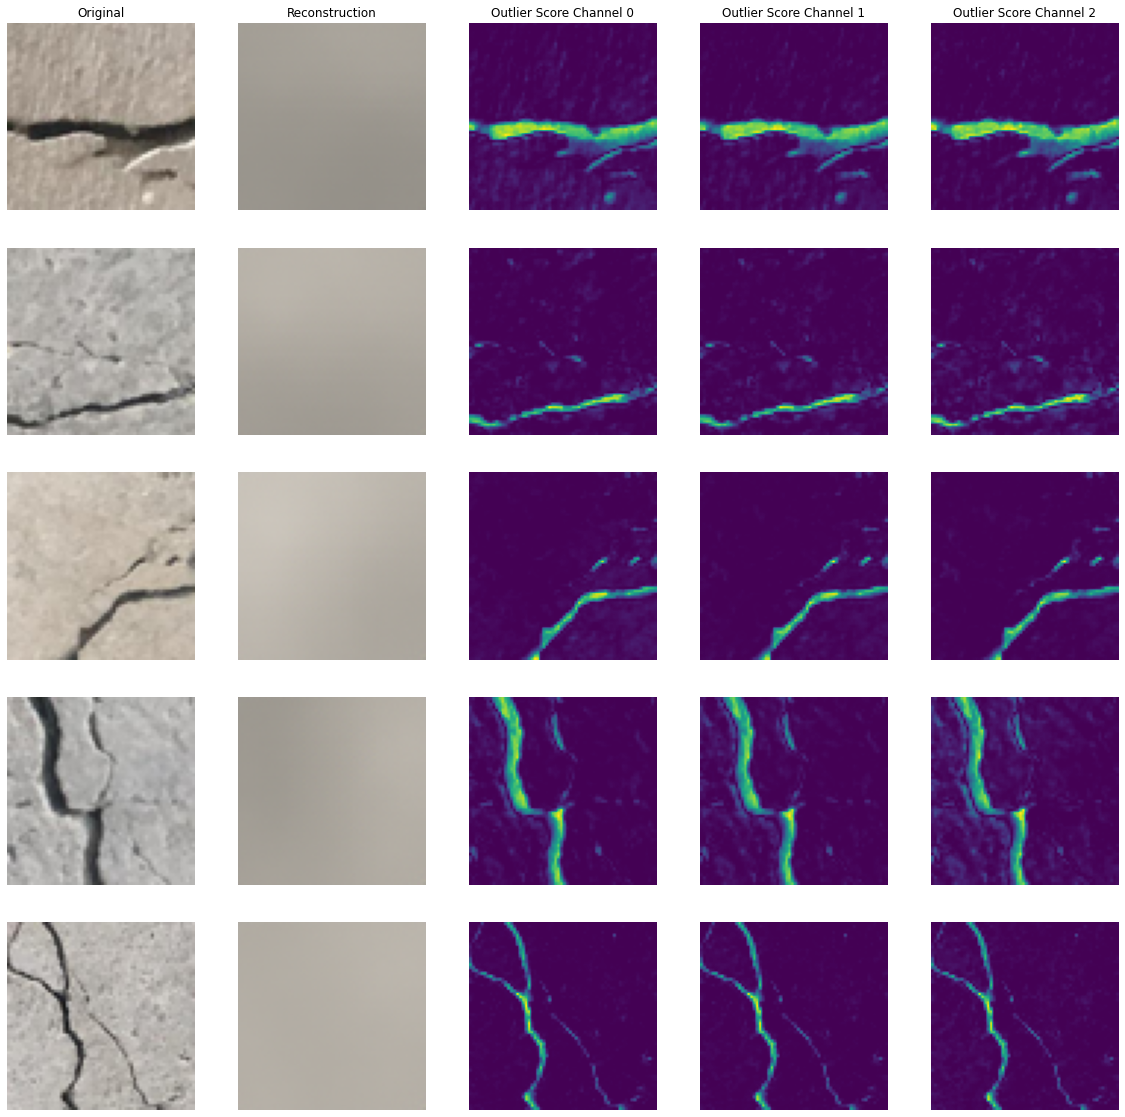

In [18]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)